# Cassava Leaf Disease Classification
Details: [kaggle.com](https://www.kaggle.com/c/cassava-leaf-disease-classification)

## Prepare kaggle dataset

In [7]:
!pip install -q kaggle
!wget -q https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/Project/kaggle/key/kaggle.json -O ~/.kaggle/kaggle.json
!sleep 5; chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05           1280  
sevgisarac/temperature-change                          Temperature change                                  778KB  2020-12-24 20:06:36           1327  
jorgesandoval/wind-power-generation                    Wind Power Generation Data                          245KB  2021-01-07 18:45:08            529  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data                    748MB  2021-01-20 21:48:02            177  
fedesoriano/cern-electron-collision-data               CERN electron collision data           

In [8]:
!mkdir -p Dataset
!kaggle competitions download -c cassava-leaf-disease-classification --path Dataset

 88% 191M/217M [00:02<00:00, 89.8MB/s]
100% 217M/217M [00:02<00:00, 88.5MB/s]
 90% 196M/217M [00:01<00:00, 173MB/s]
100% 217M/217M [00:01<00:00, 169MB/s]
 96% 208M/216M [00:01<00:00, 115MB/s] 
100% 216M/216M [00:02<00:00, 110MB/s]
 97% 210M/216M [00:01<00:00, 138MB/s]
100% 216M/216M [00:01<00:00, 139MB/s]
 99% 215M/217M [00:02<00:00, 92.2MB/s]
100% 217M/217M [00:02<00:00, 104MB/s] 
 91% 196M/216M [00:01<00:00, 103MB/s]
100% 216M/216M [00:01<00:00, 121MB/s]
 97% 209M/216M [00:04<00:00, 39.6MB/s]
100% 216M/216M [00:04<00:00, 53.2MB/s]
 93% 201M/217M [00:01<00:00, 129MB/s]
100% 217M/217M [00:01<00:00, 145MB/s]
 92% 198M/216M [00:02<00:00, 96.6MB/s]
100% 216M/216M [00:02<00:00, 102MB/s] 
 95% 204M/214M [00:02<00:00, 109MB/s] 
100% 214M/214M [00:02<00:00, 84.1MB/s]
100% 215M/215M [00:05<00:00, 36.9MB/s]
100% 215M/215M [00:05<00:00, 38.1MB/s]
 97% 207M/214M [00:05<00:00, 16.6MB/s]
100% 214M/214M [00:05<00:00, 37.5MB/s]
100% 217M/218M [00:03<00:00, 72.7MB/s]
100% 218M/218M [00:03<00:00, 59.7M

In [9]:
import zipfile
import shutil, pathlib
from tqdm.auto import tqdm

def unzip_file(filename, target_path='.'):
  zf = zipfile.ZipFile(filename, 'r')
  zf.extractall(target_path)
  zf.close()

def unzip_files(filename_list, target_path='.'):
  for filename in tqdm(zip_files):
    unzip_file(filename, target_path)

def create_path(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def remove_path(path):
  shutil.rmtree(path, ignore_errors=True)

def recreate_path(path):
  remove_path(path)
  create_path(path)

In [10]:
import glob
zip_files = glob.glob('Dataset/*.zip')
unzip_files(zip_files, target_path='Dataset')

## Preprocessing

In [2]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from PIL import Image


# def resize_image(image, target_size=(100,100)):
#     img = Image.fromarray(image)
#     img = img.resize(target_size, Image.ANTIALIAS)
#     img = np.asarray(img)
#     return img

# """ 
# I recommend to see following websites:
#   * https://stepup.ai/exploring_data_augmentation_keras/
#   * https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# """
# # create generator
# datagen = ImageDataGenerator()
# train_it = datagen.flow_from_directory('data/train/', class_mode='binary')
# val_it = datagen.flow_from_directory('data/validation/', class_mode='binary')
# test_it = datagen.flow_from_directory('data/test/', class_mode='binary')



In [3]:
import os
import pandas as pd

data_path = "Dataset/"
train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(label_class)
func_num_or_list = lambda func, x: func(x) if isinstance(x, (list,np.ndarray,tf.Tensor)) else func([x])[0] 
label_encode = lambda arr_str: func_num_or_list(label_encoder.transform,arr_str)
label_decode = lambda arr: func_num_or_list(label_encoder.inverse_transform,arr)

label_onehotEncoder = OneHotEncoder()
label_onehotEncoder.fit(np.arange(5).reshape(-1,1))
def onehot_decode(arr):
  np_arr = arr.numpy() if isinstance(arr, tf.Tensor) else np.array(arr)
  if len(np_arr.shape) is 1: np_arr = np_arr.reshape(1,-1)
  return label_onehotEncoder.inverse_transform(np_arr).squeeze() 
label_name = lambda arr: lnabel_decode(onehot_decode(arr).tolist()).tolist()

pd.DataFrame(label_encoder.classes_, columns=['Label names'])

,Label names
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [5]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [6]:
from functools import partial
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = "gs://kds-b38ce1b823c3ae623f5691483dbaa0f0363f04b0d6a90b63cf69946e"
BATCH_SIZE = 32
IMAGE_SIZE = [512, 512]
DEFAULT_FUNC = lambda n:n

def decode_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, image_size)
    return image

def read_tfrecord(example, labeled, image_size, label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = image_transform(decode_image(example["image"], image_size))
    if labeled:
        label = label_transform(tf.cast(example["target"], tf.int32))
        return image, label
    return image

def load_dataset(filenames, labeled, image_size, label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform), 
        num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, batch_size=BATCH_SIZE, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC):
    dataset = load_dataset(filenames, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset



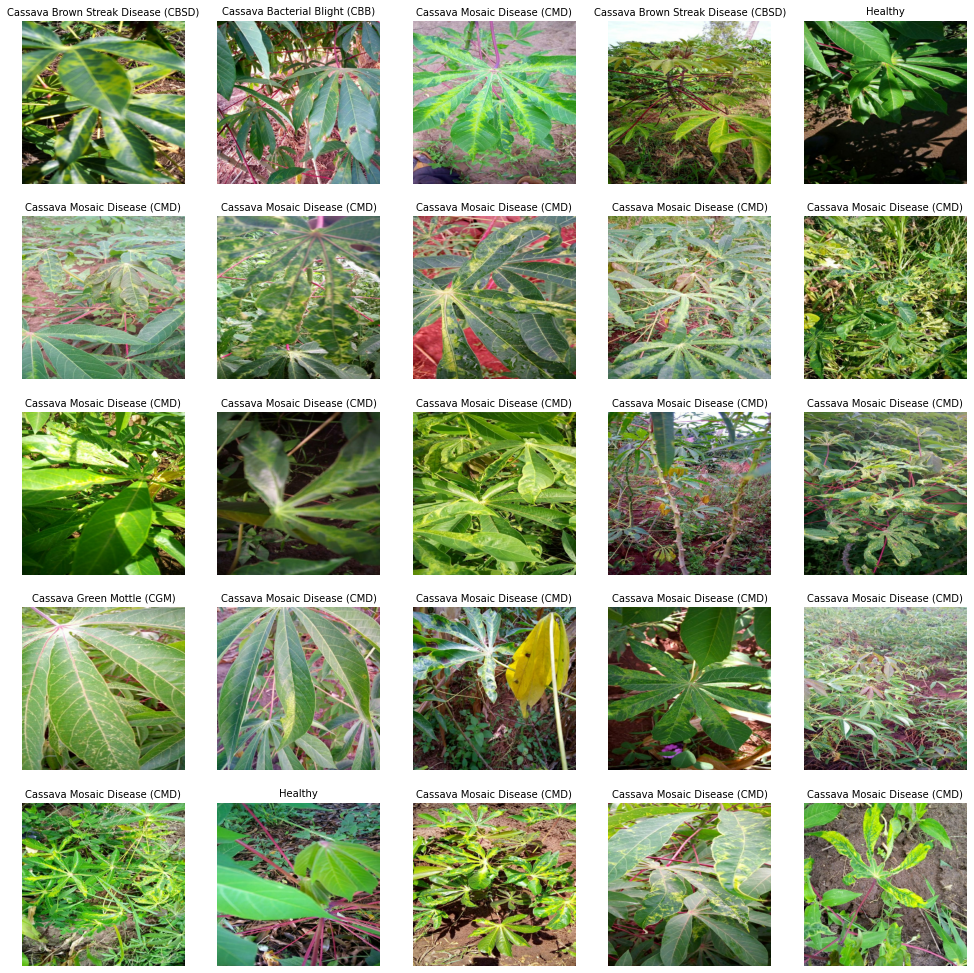

In [7]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7, 7))
    plt.tight_layout()
    plt.subplots_adjust(right=2., top=2.)
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(label_decode(label_batch[n]), fontsize=10)
        plt.axis("off")
    plt.show()

sample_dataset = get_dataset(["Dataset/ld_train15-1327.tfrec"])
image_batch, label_batch = next(iter(sample_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [8]:
batch_size = 32
label_transform = lambda x: tf.one_hot(x, depth=5)
image_transform = lambda x: x/255.

sample_dataset = get_dataset(["Dataset/ld_train15-1327.tfrec"], label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
image_batch, label_batch = next(iter(sample_dataset))


In [9]:
label_batch

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [10]:
image_batch

<tf.Tensor: shape=(32, 512, 512, 3), dtype=float32, numpy=
array([[[[0.34117648, 0.5372549 , 0.08627451],
         [0.33333334, 0.5254902 , 0.07450981],
         [0.3372549 , 0.5254902 , 0.08627451],
         ...,
         [0.38431373, 0.5921569 , 0.02745098],
         [0.31764707, 0.5411765 , 0.        ],
         [0.29803923, 0.5372549 , 0.        ]],

        [[0.3529412 , 0.54901963, 0.11372549],
         [0.33333334, 0.5254902 , 0.09803922],
         [0.3254902 , 0.5137255 , 0.08235294],
         ...,
         [0.38039216, 0.5882353 , 0.03137255],
         [0.3137255 , 0.5372549 , 0.        ],
         [0.3137255 , 0.54509807, 0.        ]],

        [[0.36078432, 0.54901963, 0.14901961],
         [0.32156864, 0.50980395, 0.10980392],
         [0.31764707, 0.5019608 , 0.09411765],
         ...,
         [0.36862746, 0.57254905, 0.04705882],
         [0.3137255 , 0.5254902 , 0.        ],
         [0.30588236, 0.53333336, 0.        ]],

        ...,

        [[0.36078432, 0.38431373,

##### Create Datasets

In [11]:
FILENAMES = tf.io.gfile.glob("Dataset/ld_train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

# TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
# print("Test TFRecord Files:", len(TEST_FILENAMES))

num_classes = len(label_class)
batch_size = 16
label_transform = lambda x: tf.one_hot(x, depth=num_classes)
image_transform = lambda x: x/255.

train_dataset = get_dataset(TRAINING_FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
valid_dataset = get_dataset(VALID_FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
# test_dataset = get_dataset(TEST_FILENAMES, labeled=False)

Train TFRecord Files: 14
Validation TFRecord Files: 2


## Training:

In [19]:
# initial_learning_rate = 0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
# )

# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#     "melanoma_model.h5", save_best_only=True
# )

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#     patience=10, restore_best_weights=True
# )

In [20]:
# base_model = tf.keras.applications.Xception(
#     input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
# )

# base_model.trainable = False

# inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3], name='input')
# x = tf.keras.applications.xception.preprocess_input(inputs)
# x = base_model(x)
# x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
# x = tf.keras.layers.Dense(8, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.7)(x)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# # model.compile(
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
# #     loss="binary_crossentropy",
# #     metrics=[tf.keras.metrics.AUC(name="auc"),'accuracy']
# # )


In [11]:
input = tf.keras.layers.Input(shape=(*IMAGE_SIZE,3), name='input')
# model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)
model_base = tf.keras.applications.Xception(weights='imagenet', input_tensor=input, include_top=False)
# input_model_base = tf.keras.applications.xception.preprocess_input(input)
# model_base = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
# Freeze all the layers
for layer in model_base.layers[:]:
    layer.trainable = False

avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model_base(input))
hidden_dense1 = tf.keras.layers.Dense(1024,  activation='relu', name='hidden_dense1')(avg_pool)
hidden_dense2 = tf.keras.layers.Dense(64,  activation='relu', name='hidden_dense2')(hidden_dense1)
output = tf.keras.layers.Dense(num_classes,  activation='softmax', name='output')(hidden_dense2)
model = tf.keras.models.Model(inputs=input, outputs=output, name='Model')


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', 'binary_accuracy', tf.keras.metrics.AUC(name="AUC")])

model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
hidden_dense1 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
hidden_dense2 (Dense)        (None, 64)                65600     
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 23,025,581
Trainable params: 2,164,101
Non-trainable params: 20,861,480
_________________________________________

In [12]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)

model.save('model1.h5')

Epoch 1/10
586/586 [==============================] - 545s 895ms/step - loss: 0.8326 - auc: 0.9092 - accuracy: 0.6905 - val_loss: 0.6619 - val_auc: 0.9449 - val_accuracy: 0.7567
Epoch 2/10
586/586 [==============================] - 532s 892ms/step - loss: 0.6695 - auc: 0.9430 - accuracy: 0.7530 - val_loss: 0.6226 - val_auc: 0.9514 - val_accuracy: 0.7713
Epoch 3/10
586/586 [==============================] - 533s 892ms/step - loss: 0.6056 - auc: 0.9534 - accuracy: 0.7792 - val_loss: 0.6238 - val_auc: 0.9516 - val_accuracy: 0.7739
Epoch 4/10
586/586 [==============================] - 533s 894ms/step - loss: 0.5706 - auc: 0.9586 - accuracy: 0.7898 - val_loss: 0.6169 - val_auc: 0.9527 - val_accuracy: 0.7720
Epoch 5/10
586/586 [==============================] - 533s 893ms/step - loss: 0.5484 - auc: 0.9615 - accuracy: 0.7970 - val_loss: 0.6358 - val_auc: 0.9499 - val_accuracy: 0.7765
Epoch 6/10
586/586 [==============================] - 533s 894ms/step - loss: 0.5193 - auc: 0.9654 - accuracy:

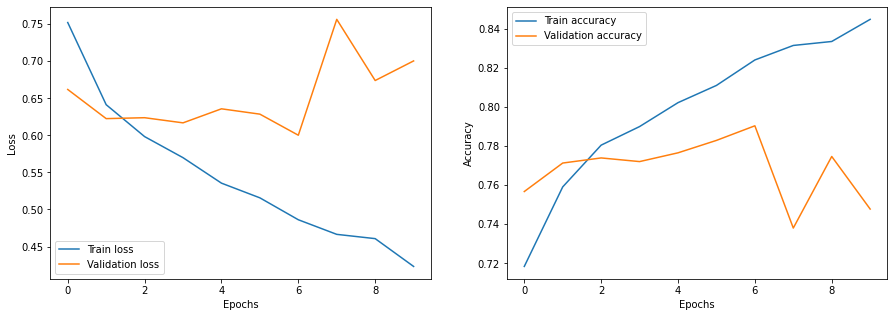

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('model1-history.png')
plt.show()

In [15]:
import tensorflow as tf
input = tf.keras.layers.Input(shape=(*IMAGE_SIZE,3), name='input')
# model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)
model_base = tf.keras.applications.Xception(weights='imagenet', input_tensor=input, include_top=False)
for layer in model_base.layers[:]: layer.trainable = False
for layer in model_base.layers[:7]: layer.trainable = True

avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model_base(input))
hidden_dense = tf.keras.layers.Dense(1024,  activation='relu', name='hidden_dense1')(avg_pool)
dropout = tf.keras.layers.Dropout(0.3, name='dropout')(hidden_dense)
output = tf.keras.layers.Dense(num_classes,  activation='softmax', name='output')(dropout)
model = tf.keras.models.Model(inputs=input, outputs=output, name='Model')


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model2.h5", save_best_only=True)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', 'binary_accuracy', tf.keras.metrics.AUC(name="AUC")])

model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
hidden_dense1 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 5)                 5125      
Total params: 22,964,781
Trainable params: 2,122,789
Non-trainable params: 20,841,992
_________________________________________

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)

model.save('model2.h5')

Epoch 1/10
    394/Unknown - 399s 983ms/step - loss: 0.9124 - accuracy: 0.6756 - binary_accuracy: 0.8844 - AUC: 0.8924

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('model1-history.png')
plt.show()

In [33]:
input = tf.keras.layers.Input(shape=(*IMAGE_SIZE,3), name='input')
conv = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name='conv2d')(input)
conv.shape[1:]

TensorShape([512, 512, 32])

In [21]:
sorted([i for i in os.listdir('Dataset') if not i.endswith('.tfrec')])

['1000015157.jpg',
 '1000201771.jpg',
 '100042118.jpg',
 '1000723321.jpg',
 '1000812911.jpg',
 '1000837476.jpg',
 '1000910826.jpg',
 '1001320321.jpg',
 '1001723730.jpg',
 '1001742395.jpg',
 '1001749118.jpg',
 '100204014.jpg',
 '1002088496.jpg',
 '1002255315.jpg',
 '1002394761.jpg',
 '1003218714.jpg',
 '1003298598.jpg',
 '1003442061.jpg',
 '1003888281.jpg',
 '1003987001.jpg',
 '2216849948.jpg',
 'label_num_to_disease_map.json',
 'ld_train00-1338.tfrec.zip',
 'ld_train01-1338.tfrec.zip',
 'ld_train02-1338.tfrec.zip',
 'ld_train03-1338.tfrec.zip',
 'ld_train04-1338.tfrec.zip',
 'ld_train05-1338.tfrec.zip',
 'ld_train06-1338.tfrec.zip',
 'ld_train07-1338.tfrec.zip',
 'ld_train08-1338.tfrec.zip',
 'ld_train09-1338.tfrec.zip',
 'ld_train10-1338.tfrec.zip',
 'ld_train11-1338.tfrec.zip',
 'ld_train12-1338.tfrec.zip',
 'ld_train13-1338.tfrec.zip',
 'ld_train14-1338.tfrec.zip',
 'ld_train15-1327.tfrec.zip',
 'sample_submission.csv',
 'train.csv']

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

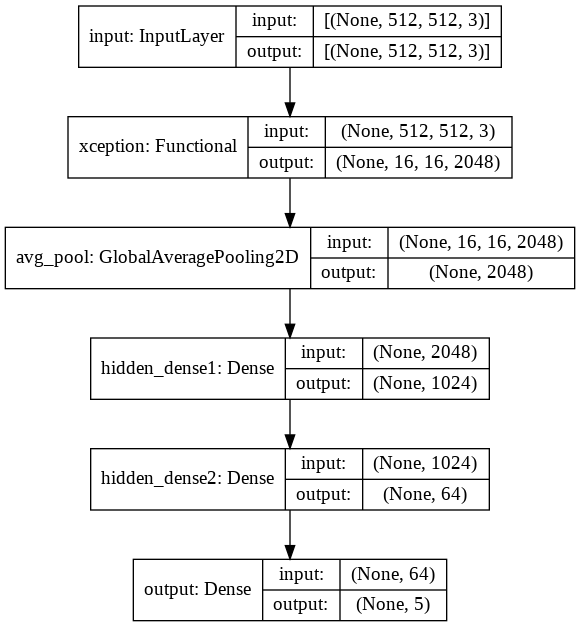

In [23]:
tf.keras.applications.Xception().summary()
tf.keras.utils.plot_model(tf.keras.applications.Xception(),'Xception.png',True)
tf.keras.utils.plot_model(model_base,'model_base.png',True)
tf.keras.utils.plot_model(model,'model1.png', True)

In [ ]:
# # from tensorflow.keras.utils import plot_model

# # load the model
# model_base = tf.keras.applications.DenseNet121(weights='imagenet')
# # Freeze all the layers
# for layer in model_base.layers[:]:
#     layer.trainable = False

# output = tf.keras.layers.Dense(11,  activation='sigmoid', name='output')(model_base.layers[-2].output)
# model = tf.keras.models.Model(inputs=model_base.inputs, outputs=output)
# model.summary()
# # plot_model(pre_model, show_shapes=True)

## Test:

In [ ]:

# history = model.fit(
#     train_dataset,
#     epochs=64,
#     # verbose=2,
#     validation_data=valid_dataset,
#     callbacks=[checkpoint_cb, early_stopping_cb],
# )

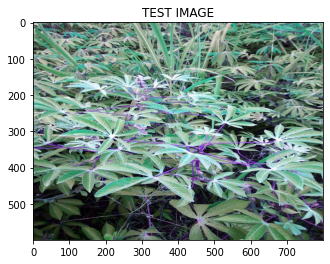

In [ ]:
import matplotlib.pyplot as plt
import cv2
BATCH_SIZE = 18
IMG_SIZE = 224

test_img_path = os.path.join(data_path,"2216849948.jpg")

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).reshape(-1, IMG_SIZE, IMG_SIZE, 3)/255

plt.figure(figsize=(8,4))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])
plt.show()

In [24]:
%reset -f

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])? 


In [ ]:
# preds = []
# ss = pd.read_csv(data_path+'sample_submission.csv')

# for image in ss.image_id:
#     img = tf.keras.preprocessing.image.load_img(data_path+'test_images/' + image)
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
#     img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
#     prediction = model_model.predict(img/255)
#     preds.append(np.argmax(prediction))

# my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
# my_submission.to_csv('submission.csv', index=False)

In [ ]:
# raw_example = next(iter(data))


In [ ]:
# raw_example

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x99\xc4\x0b\n\x0f\n\x06target\x12\x05\x1a\x03\n\x01\x00\n \n\nimage_name\x12\x12\n\x10\n\x0e1000015157.jpg\n\xe2\xc3\x0b\n\x05image\x12\xd7\xc3\x0b\n\xd3\xc3\x0b\n\xcf\xc3\x0b\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x02\x00\x02\x00\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x05\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x03\x04\x05\x07\x08\t\x02\x01\x00\n\xff\xc4\x00L\x10\x00\x01\x03\x03\x03\x02\x04\x04\x05\x02\x03\x06\x03\x07\x00\x0b\x01\x02\x03\x04\